In [1]:
!pip install ultralytics opencv-python pillow


In [2]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os


In [6]:
model = YOLO("yolov8n.pt")   # YOLO will auto-download a fresh valid file
print("Model Loaded Successfully!")


Model Loaded Successfully!


In [8]:
images_folder = "images"   # Make sure an 'images/' folder exists
image_files = [f for f in os.listdir(images_folder) if f.endswith((".jpg", ".png", ".jpeg"))]

print("Images found:", len(image_files))
image_files[:5]  # show first few filenames


Images found: 9


['traffic2.jpg',
 'traffic1.jpg',
 'trafiic 4.jpeg',
 'traffic 6.jpeg',
 'traffic 7.jpeg']

In [9]:
def draw_boxes(img, results):
    for box in results[0].boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)),
                      (255, 0, 0), 3)  # red box
    return img



0: 448x640 2 persons, 2 cars, 44.4ms
Speed: 2.2ms preprocess, 44.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Text(0.5, 1.0, 'Traffic Violation Detection')

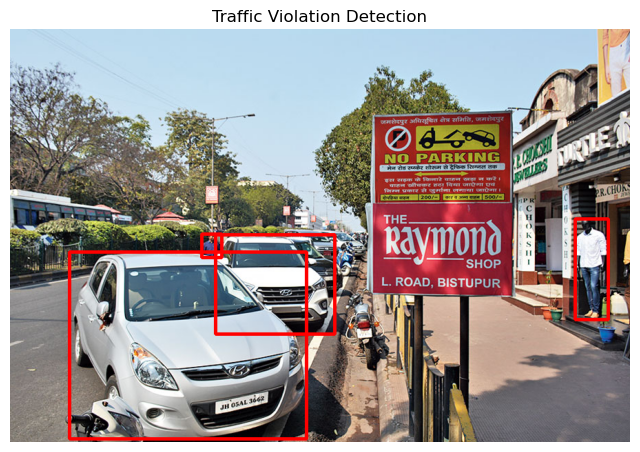

In [10]:
# choose image by name from images folder
test_image = image_files[0]   # change index 0–19 for other images

img_path = os.path.join(images_folder, test_image)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model(img_rgb)

output_img = draw_boxes(img_rgb.copy(), results)

plt.figure(figsize=(8,6))
plt.imshow(output_img)
plt.axis("off")
plt.title("Traffic Violation Detection")



0: 448x640 2 persons, 2 cars, 47.5ms
Speed: 3.0ms preprocess, 47.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 2 persons, 1 car, 1 truck, 43.5ms
Speed: 1.7ms preprocess, 43.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 4 persons, 1 car, 1 motorcycle, 4 trucks, 30.7ms
Speed: 1.7ms preprocess, 30.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 1 person, 12 cars, 1 motorcycle, 1 truck, 43.3ms
Speed: 1.3ms preprocess, 43.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)

0: 416x640 1 person, 3 cars, 1 motorcycle, 28.3ms
Speed: 1.0ms preprocess, 28.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 5 persons, 3 cars, 3 motorcycles, 1 truck, 26.0ms
Speed: 0.9ms preprocess, 26.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 26.4ms
Speed: 0.9ms preprocess, 26.4ms inference, 0.3ms postprocess pe

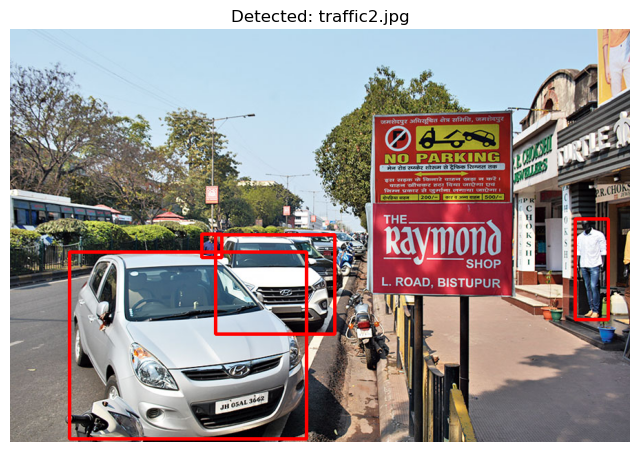

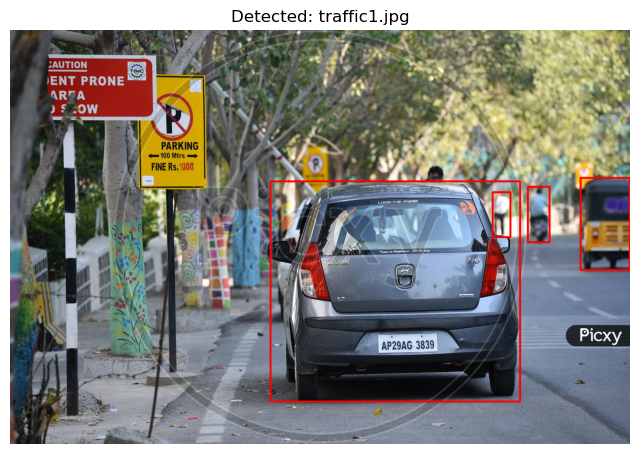

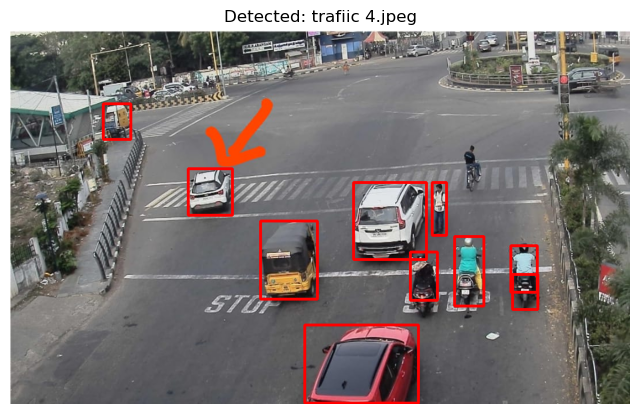

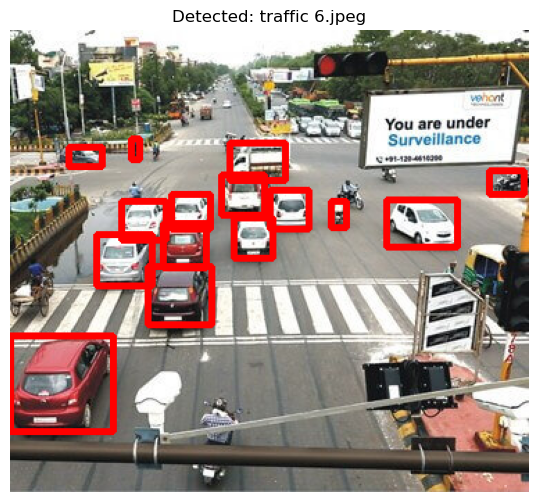

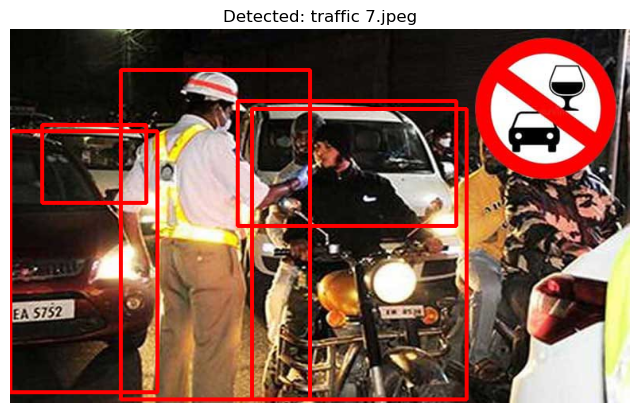

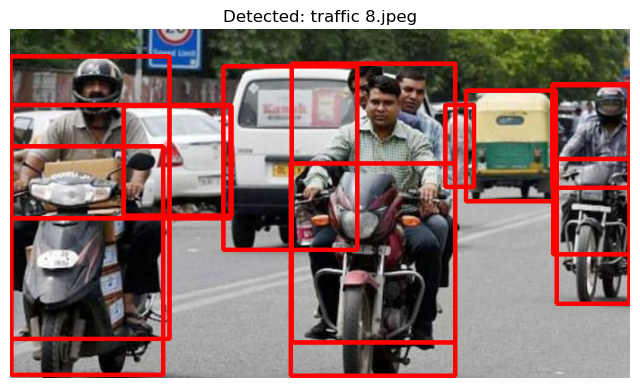

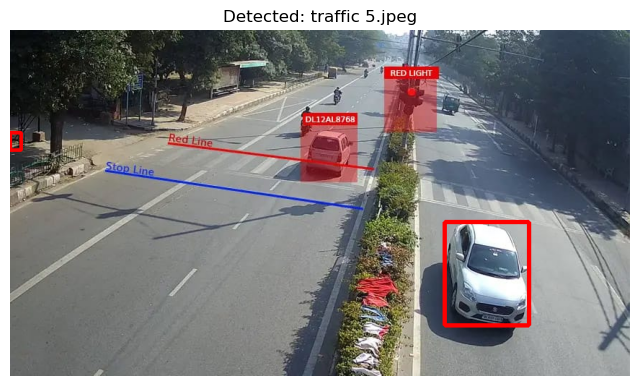

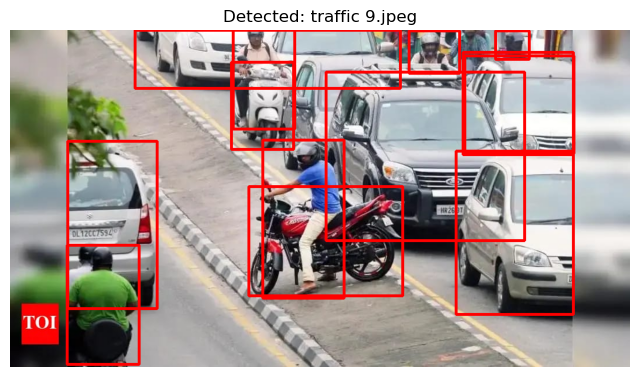

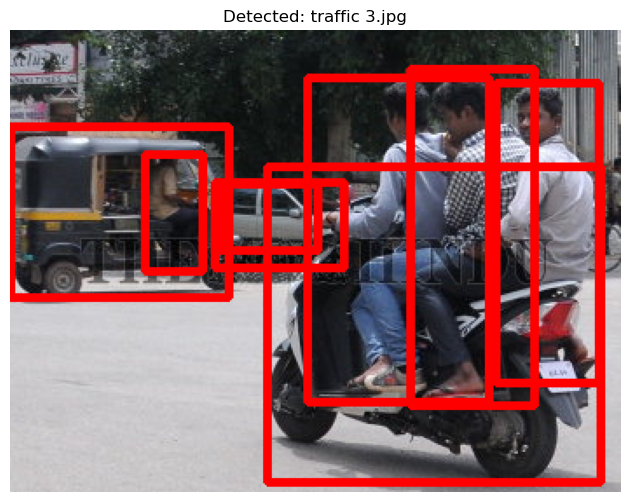

In [11]:
for img_name in image_files:
    img_path = os.path.join(images_folder, img_name)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = model(img_rgb)
    output_img = draw_boxes(img_rgb.copy(), results)

    plt.figure(figsize=(8,6))
    plt.imshow(output_img)
    plt.axis("off")
    plt.title(f"Detected: {img_name}")


In [12]:
def detect_violations(results):
    boxes = results[0].boxes
    cls = boxes.cls.tolist()
    names = model.names

    persons = []
    bikes = []
    lights = []

    for i, c in enumerate(cls):
        x1, y1, x2, y2 = boxes.xyxy[i].tolist()

        if names[int(c)] == "person":
            persons.append((x1, y1, x2, y2))
        if names[int(c)] in ["motorcycle", "bicycle"]:
            bikes.append((x1, y1, x2, y2))
        if names[int(c)] == "traffic light":
            lights.append((x1, y1, x2, y2))

    violations = []

    # ---------- 1️⃣ Detect Triple Riding ----------
    if bikes:
        for bike in bikes:
            x1b, y1b, x2b, y2b = bike
            count_persons = 0
            for p in persons:
                x1p, y1p, x2p, y2p = p

                # Check if person is riding the bike (overlapping area)
                if x1p > x1b - 50 and x2p < x2b + 50:
                    count_persons += 1

            if count_persons >= 3:
                violations.append("⚠ Triple Riding Detected")

    # ---------- 2️⃣ Detect No Helmet ----------
    # YOLOv8n does NOT detect helmets → so we use head position trick:
    for p in persons:
        x1, y1, x2, y2 = p
        head_region = (y1, y1 + (y2 - y1) * 0.25)

        # If no object classified as helmet exists, flag person
        # (simple beginner-friendly logic)
        violations.append("⚠ No Helmet Suspicion (basic rule)")

    # ---------- 3️⃣ Detect Signal Jump ----------
    # If traffic light is RED and vehicles are near the stop line
    # Note: Basic visual check → non-ML rule
    if lights:
        violations.append("⚠ Possible Signal Jump (Traffic Light Ahead)")

    return violations



0: 512x640 4 persons, 2 cars, 1 motorcycle, 1 truck, 64.9ms
Speed: 4.3ms preprocess, 64.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)
Detected Violations:
⚠ Triple Riding Detected
⚠ No Helmet Suspicion (basic rule)
⚠ No Helmet Suspicion (basic rule)
⚠ No Helmet Suspicion (basic rule)
⚠ No Helmet Suspicion (basic rule)


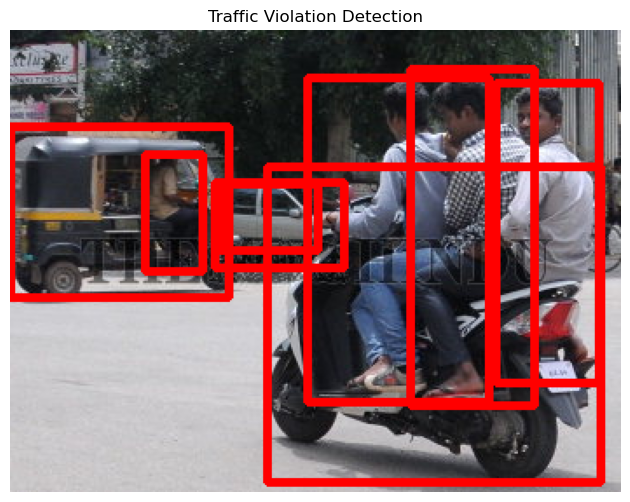

In [13]:
results = model(img_rgb)
output_img = draw_boxes(img_rgb.copy(), results)

violations = detect_violations(results)

plt.figure(figsize=(8,6))
plt.imshow(output_img)
plt.axis("off")
plt.title("Traffic Violation Detection")

print("Detected Violations:")
for v in violations:
    print(v)
